# **Binary Classification**
In this notebook, we are performing binary classifications on the tweets, focusing on the `negative` and `positive` records. This step is important to our project as it will help us work with the specified classes marking a milestone before we engage other classes.

The activities in the notebook will include;
- Importing relevant packages and loading the dataset

- Choosing relevant columns and splitting them into train, test and validation sets.

- Feature engineering.

- Training binary classification models.

## **Initial preparation**
In this step, we are importing the relevant packages and basically preparaing our data before we begin training our models.

### *Import Relevant Libraries*

In [1]:
# Import relevant packages
import pandas as pd
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [16]:
# Load dataset
text_cleaned = pd.read_csv("../../assets/Cleaned_Tweets.csv")

# Preview the first 5 rows
text_cleaned.head()                   

,tweet,emotion,product_filled,cleaned_tweets,text_length
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...,12
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...,14
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw,6
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...,9
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...,15


As we are performing binary classification in this notebook, in the next cell we are filtering the dataset to remain with records with `positive` and `negative` emotions.

In [3]:
# Filter the dataset to remain with negative and positive emotion
binary_df = text_cleaned[text_cleaned["emotion"].isin(['positive', 'negative'])]

# Preview filtered data
binary_df.head()

,tweet,emotion,product_filled,cleaned_tweets,text_length
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...,12
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...,14
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw,6
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...,9
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...,15


### *Preprocessing*
After successfully separating the data to remain with only binary classes, we are now preparing our data for modeling by;
- Selecting columns for the predictor and target variables.

- Converting our target variable to binary (0, 1)

- Splitting the data into test and train sets.

Here we are using the `cleaned_tweets` column as our predictor and the `emotion` column as our target variable.

In [4]:
# Put predictor and target columns in their respective variables.
X_binary = binary_df["cleaned_tweets"]
y_binary = binary_df["emotion"]

# Covert the y_binary column to binary.
y_binary = y_binary.map({'negative': 0, 'positive': 1})

# Split the data into train and test sets.
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

In previous projects, we've had issues in the evaluation step due to validating our models using the train set. Here we are splitting our training set further to have;
- **temp set**- This is the dataset that we are using to train the models.

- **val set**- This is the dataset that we are using to evaluate how our model generalizes to new data.

This is important because it helps us train our models better and also ensures we only use our hold out dataset after choosing our final model.

In [5]:
# Splitting the train set into temp and validation sets.
Xb_temp, Xb_val, yb_temp, yb_val= train_test_split(Xb_train, yb_train, test_size=0.2, random_state=42, stratify=yb_train)

We have successfully prepared our data for modeling.

## **Model training**
In this section, we are training our models to correctly classify whether a tweet is negative or positive.

This will include models such as;
- Logistic Regression

- SVM

- Random Forest

- XGBoost

- Gradient Descent

### *Baseline Model*
Here we are using TF-IDF to vectorize our data, and logistic regression to classify it.

In [6]:
# Define pipeline
sentiment_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit pipeline
sentiment_pipeline.fit(Xb_temp, yb_temp)

# Predictions
y_pred = sentiment_pipeline.predict(Xb_val)

# Evaluation
print("Classification Report:\n", classification_report(yb_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.07      0.12        91
           1       0.85      1.00      0.92       477

    accuracy                           0.85       568
   macro avg       0.85      0.53      0.52       568
weighted avg       0.85      0.85      0.79       568

Confusion Matrix:
 [[  6  85]
 [  1 476]]


#### *SUMMARY:*
Our overall model performance is terrible, the classification report shows very poor recall for class 0 with only 7%, meaning that the model is barely predicting any negatives correctly and it’s biased toward predicting positive, class 1, almost all the time.

This is a clear indication that we have a class imbalance issue. It heavily points out that we may:
- have a heavily skewed class distribution.

Due to this, the model is learning features that mostly correlate with positives.

In the next cell, we are inspecting the class distribution in our dataset.

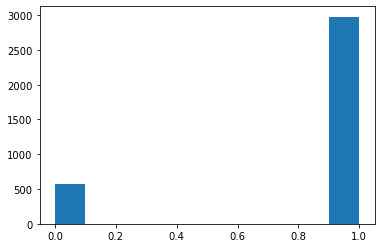

In [7]:
# Inspect class distribution
plt.hist(y_binary);

### *Applying SMOTE*
To deal with the class imbalance, we are applying SMOTE to the y_binary.

In [8]:
# Define pipeline
smote_pipeline = ImbPipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, class_weight=None))  # class_weight not needed since we use SMOTE
])

# Fit pipeline
smote_pipeline.fit(Xb_temp, yb_temp)

# Predictions
y_pred = smote_pipeline.predict(Xb_val)

# Evaluation
print("Classification Report:\n", classification_report(yb_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53        91
           1       0.91      0.91      0.91       477

    accuracy                           0.85       568
   macro avg       0.72      0.72      0.72       568
weighted avg       0.85      0.85      0.85       568

Confusion Matrix:
 [[ 48  43]
 [ 42 435]]


#### *SUMMARY:*
This model performed better than the baseline model, this is attributable to SMOTE. SMOTE helped the model pick up more of the minority class, class 0, compared to the previous model.

- Recall for class 0 went from 0.07 to 0.53, a big improvement meaning that now the model catches more positive cases.

- Precision for class 0 dropped from 0.86 to 0.54, which is expected, because SMOTE increases false positives.

- Class 1 stayed strong with 0.91 precision/recall, while overall accuracy stayed at 85%, but the model is now more balanced in detecting both classes.


### *Parameter Tuning*

In [22]:
# Define the parameters
param_grid = {
    "tfidf__max_features": [3000, 5000, 7000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"]
}

# Grid search
grid_search = GridSearchCV(
    smote_pipeline,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(Xb_temp, yb_temp)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Xb_val)

print("\nClassification Report:\n", classification_report(yb_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(yb_val, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   36.4s finished


Best Parameters: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1)}

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.48      0.52        91
           1       0.90      0.93      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.71      0.72       568
weighted avg       0.85      0.86      0.85       568


Confusion Matrix:
 [[ 44  47]
 [ 33 444]]


#### *SUMMARY:*
This model, compared to the previous one improved, but barely;
- Recall for class 0 went from 0.53  0.48.

- Recall for class 1 stayed strong at 0.93.

However, despite the stillness and drop, the overall accuracy went up to 86%.

### *Training Multiple Binary Models*
In this section, we are training several models simultaneously.

In [ ]:
# Define all models
models = {
    "SVM": LinearSVC(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}

# Create a pipeline
for name, clf in models.items():
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
     # Fit
    pipe.fit(Xb_temp, yb_temp)
    
    # Predict
    y_pred = pipe.predict(Xb_val)
    
    # Evaluate
    acc = accuracy_score(yb_val, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(yb_val, y_pred))
    
    results[name] = acc

print("\nSummary:", results)
    


SVM Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.60      0.49      0.54        91
           1       0.91      0.94      0.92       477

    accuracy                           0.87       568
   macro avg       0.75      0.72      0.73       568
weighted avg       0.86      0.87      0.86       568


Random Forest Accuracy: 0.8908
              precision    recall  f1-score   support

           0       0.84      0.40      0.54        91
           1       0.90      0.99      0.94       477

    accuracy                           0.89       568
   macro avg       0.87      0.69      0.74       568
weighted avg       0.89      0.89      0.87       568



c:\Users\PC\anaconda33\envs\learn-env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.8574
              precision    recall  f1-score   support

           0       0.61      0.31      0.41        91
           1       0.88      0.96      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.63      0.66       568
weighted avg       0.84      0.86      0.84       568


Gradient Boosting Accuracy: 0.8380
              precision    recall  f1-score   support

           0       0.49      0.49      0.49        91
           1       0.90      0.90      0.90       477

    accuracy                           0.84       568
   macro avg       0.70      0.70      0.70       568
weighted avg       0.84      0.84      0.84       568


Summary of Results: {'SVM': 0.8661971830985915, 'Random Forest': 0.8908450704225352, 'XGBoost': 0.8573943661971831, 'Gradient Boosting': 0.8380281690140845}


#### *SUMMARY:*
SVM

Class 0: precision 0.60, recall 0.49, f1 0.54
→ Only ~49% of negative tweets were correctly identified. When it predicts negative, it’s right 60% of the time.

Class 1: precision 0.91, recall 0.94, f1 0.92
→ Very good at detecting positives.

Macro F1: 0.73 → average performance across classes.

Weighted F1: 0.86 → reflects class imbalance.

Random Forest

Class 0: precision 0.84, recall 0.40, f1 0.54
→ Predicts negatives less often (recall 0.40) but when it does, it’s usually correct (precision 0.84).

Class 1: precision 0.90, recall 0.99, f1 0.94 → excellent detection of positives.

Accuracy highest (0.89) but minority class recall is low, so many negatives are missed.

XGBoost

Class 0: precision 0.61, recall 0.31, f1 0.41 → struggles with negatives.

Class 1: precision 0.88, recall 0.96, f1 0.92 → strong on positives.

Overall weighted F1: 0.84.

Gradient Boosting

Class 0: precision 0.50, recall 0.49, f1 0.50 → slightly better balance for negative class.

Class 1: precision 0.90, recall 0.91, f1 0.90 → good detection of positives.

Weighted F1: 0.84.

4️⃣ Key Takeaways

Minority class detection is poor across all models: recall for class 0 is below 0.5 for most models.

Random Forest & SVM are strongest overall, but still biased towards positives.

Gradient Boosting is more balanced on class 0 but has lower overall accuracy.

Macro F1 is useful here — it shows balanced performance across classes

In [11]:
# Define models and param grids
models_and_params = {
    "SVM": (
        LinearSVC(random_state=42),
        {
            "clf__C": [0.1, 1, 10]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [3, 6, 10],
            "clf__learning_rate": [0.1, 0.3]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__learning_rate": [0.05, 0.1, 0.3],
            "clf__max_depth": [3, 5]
        }
    )
}

results = {}

for name, (clf, param_grid) in models_and_params.items():
    print(f"\n Running GridSearch for {name}...")
    
    pipe = ImbPipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(Xb_temp, yb_temp)
    
    y_pred = grid.predict(Xb_val)
    
    acc = accuracy_score(yb_val, y_pred)
    print(f"{name} Best Params: {grid.best_params_}")
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(yb_val, y_pred))
    
    results[name] = {"Accuracy": acc, "Best Params": grid.best_params_}

print("\n Summary of Results:")
for model, res in results.items():
    print(f"{model}: Accuracy={res['Accuracy']:.4f}, Best Params={res['Best Params']}")


 Running GridSearch for SVM...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.6s finished


SVM Best Params: {'clf__C': 1}
SVM Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.60      0.49      0.54        91
           1       0.91      0.94      0.92       477

    accuracy                           0.87       568
   macro avg       0.75      0.72      0.73       568
weighted avg       0.86      0.87      0.86       568


 Running GridSearch for Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   40.1s finished


Random Forest Best Params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Random Forest Accuracy: 0.8908
              precision    recall  f1-score   support

           0       0.84      0.40      0.54        91
           1       0.90      0.99      0.94       477

    accuracy                           0.89       568
   macro avg       0.87      0.69      0.74       568
weighted avg       0.89      0.89      0.87       568


 Running GridSearch for XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.3min finished
c:\Users\PC\anaconda33\envs\learn-env\lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}
XGBoost Accuracy: 0.8574
              precision    recall  f1-score   support

           0       0.61      0.31      0.41        91
           1       0.88      0.96      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.63      0.66       568
weighted avg       0.84      0.86      0.84       568


 Running GridSearch for Gradient Boosting...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.0min finished


Gradient Boosting Best Params: {'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Gradient Boosting Accuracy: 0.8609
              precision    recall  f1-score   support

           0       0.59      0.43      0.50        91
           1       0.90      0.94      0.92       477

    accuracy                           0.86       568
   macro avg       0.74      0.69      0.71       568
weighted avg       0.85      0.86      0.85       568


 Summary of Results:
SVM: Accuracy=0.8662, Best Params={'clf__C': 1}
Random Forest: Accuracy=0.8908, Best Params={'clf__max_depth': None, 'clf__n_estimators': 200}
XGBoost: Accuracy=0.8574, Best Params={'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Gradient Boosting: Accuracy=0.8609, Best Params={'clf__learning_rate': 0.3, 'clf__max_depth': 3, 'clf__n_estimators': 200}


1. SVM (C=1)

Accuracy: 0.87

Class 0 recall = 0.49 → means it only catches about half of the negative tweets.

Class 1 recall = 0.94 → almost perfect on positive tweets.
⚖️ Balanced, but minority class still weak.

2. Random Forest (n_estimators=200, max_depth=None)

Accuracy: 0.89 (highest overall).

Class 0 recall = 0.40 (worse than SVM).

Class 1 recall = 0.99 (almost perfect on majority class).
⚖️ Best accuracy, but very biased towards positives. Might not be fair if you care about detecting negatives.

3. XGBoost (lr=0.3, depth=3, n_estimators=200)

Accuracy: 0.86

Class 0 recall = 0.31 (lowest so far).

Class 1 recall = 0.96 (excellent).
⚖️ Again, struggles with negatives.

4. Gradient Boosting (lr=0.3, depth=3, n_estimators=200)

Accuracy: 0.86

Class 0 recall = 0.43

Class 1 recall = 0.94
⚖️ Similar to SVM, but slightly worse balance.

🏆 Takeaway:

Random Forest gives the best accuracy (0.89) but is biased (low recall on negatives).

SVM and Gradient Boosting are more balanced (they at least get ~0.43–0.49 recall on negatives).

XGBoost underperformed here (on the minority class).

So the “best” model depends on your business goal:

If you care about catching all negative tweets (to monitor complaints), SVM or Gradient Boosting are better.

If you care more about overall accuracy, Random Forest wins.